In [21]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sys


sys.path.append("../code")

from data_load import *


In [6]:
event_df, expanded_df, lineup_lookup = load_full_match("3788741")


In [25]:
expanded_df

,event_id,team,player_name,event_type,minute,second,event_location,end_location,ff_location,teammate,actor,keeper,player_id,position
0,5c888f58-fe77-459b-ab3b-a2fa5fb8ab16,Turkey,Burak Yılmaz,Pass,0,0,"[60.0, 40.0]","[32.5, 28.8]","[43.65321648946649, 31.98843233703487]",False,False,False,None,None
1,5c888f58-fe77-459b-ab3b-a2fa5fb8ab16,Turkey,Burak Yılmaz,Pass,0,0,"[60.0, 40.0]","[32.5, 28.8]","[43.997359300214555, 45.59948277519069]",False,False,False,None,None
2,5c888f58-fe77-459b-ab3b-a2fa5fb8ab16,Turkey,Burak Yılmaz,Pass,0,0,"[60.0, 40.0]","[32.5, 28.8]","[49.675715677557776, 35.43426789099837]",False,False,False,None,None
3,5c888f58-fe77-459b-ab3b-a2fa5fb8ab16,Turkey,Burak Yılmaz,Pass,0,0,"[60.0, 40.0]","[32.5, 28.8]","[54.49371502803081, 30.093222782354946]",False,False,False,None,None
4,5c888f58-fe77-459b-ab3b-a2fa5fb8ab16,Turkey,Burak Yılmaz,Pass,0,0,"[60.0, 40.0]","[32.5, 28.8]","[58.27928594625963, 48.52844299605966]",False,False,False,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45732,feb59f80-cefc-4dea-85ea-dfb9e4efb799,Italy,Bryan Cristante,Ball Receipt*,93,3,"[97.9, 12.7]",NaN,"[109.81067719774498, 40.53852652066968]",True,False,False,None,None
45733,feb59f80-cefc-4dea-85ea-dfb9e4efb799,Italy,Bryan Cristante,Ball Receipt*,93,3,"[97.9, 12.7]",NaN,"[110.06531715706987, 7.435455413483375]",False,False,False,None,None
45734,feb59f80-cefc-4dea-85ea-dfb9e4efb799,Italy,Bryan Cristante,Ball Receipt*,93,3,"[97.9, 12.7]",NaN,"[110.56452536254375, 35.99917028882595]",False,False,False,None,None
45735,feb59f80-cefc-4dea-85ea-dfb9e4efb799,Italy,Bryan Cristante,Ball Receipt*,93,3,"[97.9, 12.7]",NaN,"[110.64685666741951, 25.912043107968028]",False,False,False,None,None


In [7]:
sample_event_id = expanded_df[expanded_df["actor"] == True]["event_id"].iloc[0]

inspect_event(expanded_df, sample_event_id)


=== Event 5c888f58-fe77-459b-ab3b-a2fa5fb8ab16 ===
Type: Pass | Team: Turkey | Minute: 0:0
Actor: Burak Yılmaz (ID 11086, Pos: Center Forward)
Event location: [60.0, 40.0] → End location: [32.5, 28.8]

Teammates visible:
 - [61.20449983761826, 48.35615121836148]
 - [67.3990704310836, 33.022183003223915]
 - [68.94771307944993, 43.704273220510764]

Opponents visible:
 - [43.65321648946649, 31.98843233703487]
 - [43.997359300214555, 45.59948277519069]
 - [49.675715677557776, 35.43426789099837]
 - [54.49371502803081, 30.093222782354946]
 - [58.27928594625963, 48.52844299605966]
 - [60.344142810748075, 30.782389893147645]


In [8]:
import numpy as np

def freeze_frame_to_grid(freeze_frame, actor_location, 
                         N=12, M=8, pitch_length=120, pitch_width=80):
    grid = np.zeros((N, M, 3), dtype=np.float32)
    cell_x = pitch_length / N
    cell_y = pitch_width / M

    def get_cell(x, y):
        i = min(N-1, int(x // cell_x))
        j = min(M-1, int(y // cell_y))
        return i, j
    
    for p in freeze_frame:
        loc = p.get("location") or p.get("ff_location")
        if not loc:
            continue
        x, y = loc
        i, j = get_cell(x, y)
        
        if p.get("actor"):
            grid[i, j, 0] = 1
        elif p.get("teammate"):
            grid[i, j, 1] += 1
        else:
            grid[i, j, 2] += 1

    if actor_location:
        i, j = get_cell(*actor_location)
        grid[i, j, 0] = 1
    
    return grid


In [9]:
sample_event = expanded_df[expanded_df["actor"] == True].iloc[0]

actor_loc = sample_event["event_location"]
freeze_frame = expanded_df[expanded_df["event_id"] == sample_event["event_id"]].to_dict("records")

grid = freeze_frame_to_grid(freeze_frame, actor_loc, N=12, M=8)

print("Grid shape:", grid.shape)   # (12, 8, 3)
print("Actor cells:", np.argwhere(grid[:,:,0] == 1))


Grid shape: (12, 8, 3)
Actor cells: [[6 4]]


In [10]:
def location_to_label(end_location, N=12, M=8, pitch_length=120, pitch_width=80):
    """
    Map end_location [x, y] into a grid cell (i, j).
    """
    if end_location is None:
        return None, None, None
    
    x, y = end_location
    cell_x = pitch_length / N
    cell_y = pitch_width / M
    
    i = min(N-1, int(x // cell_x))
    j = min(M-1, int(y // cell_y))
    
    class_index = i * M + j
    return i, j, class_index


In [13]:
sample_event = event_df[event_df["type"] == "Pass"].iloc[0]

end_loc = sample_event["end_location"]
print("End location:", end_loc)

i, j, class_idx = location_to_label(end_loc, N=12, M=8)
print(f"Grid cell: ({i},{j}), Class index: {class_idx}")


End location: [32.5, 28.8]
Grid cell: (3,2), Class index: 26


In [17]:
import numpy as np

def build_dataset(df, N=12, M=8, pitch_length=120, pitch_width=80, verbose=True):
    """
    Build dataset of (X, y) pairs from event DataFrame.
    """
    X, y, ids = [], [], []
    skipped = 0

    for _, ev in df.iterrows():
        if ev["end_location"] is None or len(ev["freeze_frame"]) == 0:
            skipped += 1
            continue

        grid = freeze_frame_to_grid(ev["freeze_frame"], ev["location"], N=N, M=M,
                                    pitch_length=pitch_length, pitch_width=pitch_width)

        # encode label
        i, j, class_idx = location_to_label(ev["end_location"], N=N, M=M,
                                            pitch_length=pitch_length, pitch_width=pitch_width)
        if class_idx is None:
            skipped += 1
            continue

        X.append(grid)
        y.append(class_idx)
        ids.append(ev["event_id"])

    if verbose:
        print(f"Processed {len(df)} events → {len(X)} valid, {skipped} skipped")

    return np.array(X), np.array(y), ids


def location_to_label(end_location, N=12, M=8, pitch_length=120, pitch_width=80):
    """
    Map an end_location into a grid cell (i, j).
    """
    if end_location is None:
        return None, None, None
        
    
    if not isinstance(end_location, (list, tuple)) or len(end_location) < 2:
        return None, None, None
    
    x, y = end_location[:2]   # take only first two coords
    cell_x = pitch_length / N
    cell_y = pitch_width / M
    
    i = min(N-1, int(x // cell_x))
    j = min(M-1, int(y // cell_y))
    
    class_index = i * M + j
    return i, j, class_index
    


In [18]:
combined = load_match_data("3788741")
df = combined_to_df(combined)

X, y, ids = build_dataset(df, N=12, M=8)


Processed 3803 events → 1730 valid, 2073 skipped


In [ ]:
def plot_event_grid(X, y, idx, ids, df, N=12, M=8, pitch_length=120, pitch_width=80):
    """
    Visualize one (X, y) pair from the dataset, with actual end_location.
    """
    grid = X[idx]
    label = y[idx]
    event_id = ids[idx]

    # Convert label back to grid cell
    i = label // M
    j = label % M

    # Get actual end_location from df
    end_loc = df[df["event_id"] == event_id]["end_location"].iloc[0]

    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_xlim(0, pitch_length)
    ax.set_ylim(0, pitch_width)
    ax.set_aspect('equal')
    ax.set_title(f"Event {event_id}\nTrue outcome cell: ({i}, {j})")

    cell_x = pitch_length / N
    cell_y = pitch_width / M

    # Draw grid
    for x in range(N+1):
        ax.axvline(x * cell_x, color='lightgrey', linestyle='--', linewidth=0.5)
    for y_ in range(M+1):
        ax.axhline(y_ * cell_y, color='lightgrey', linestyle='--', linewidth=0.5)

    # Mark outcome cell
    rect = patches.Rectangle((i*cell_x, j*cell_y), cell_x, cell_y,
                             linewidth=2, edgecolor='green', facecolor='none')
    ax.add_patch(rect)

    # Plot actor(s)
    actor_y, actor_x = np.where(grid[:,:,0] == 1)
    ax.scatter(actor_x * cell_y + cell_y/2, actor_y * cell_x + cell_x/2,
               c='red', s=100, label="Actor")

    # Plot teammates
    team_y, team_x = np.where(grid[:,:,1] > 0)
    ax.scatter(team_x * cell_y + cell_y/2, team_y * cell_x + cell_x/2,
               c='blue', s=60, label="Teammates")

    # Plot opponents
    opp_y, opp_x = np.where(grid[:,:,2] > 0)
    ax.scatter(opp_x * cell_y + cell_y/2, opp_y * cell_x + cell_x/2,
               c='black', s=60, label="Opponents")

    # Plot actual end location
    if isinstance(end_loc, (list, tuple)) and len(end_loc) >= 2:
        ax.scatter(end_loc[0], end_loc[1], c='green', s=150, marker='X', label="End Location")

    ax.legend()
    plt.show()


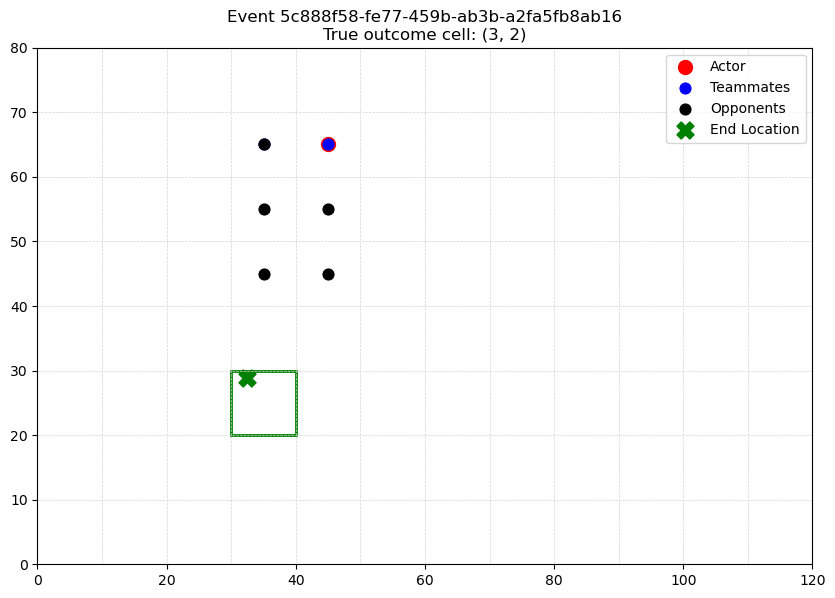

In [20]:
plot_event_grid(X, y, idx=0, ids=ids, df=df, N=12, M=8)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DecisionNet(nn.Module):
    def __init__(self, num_players, embed_dim=16, N=12, M=8, channels=3):
        super(DecisionNet, self).__init__()
        
        self.N, self.M = N, M
        self.num_classes = N * M
        
        # context grid
        self.conv = nn.Sequential(
            nn.Conv2d(channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))
        )
        
        conv_out_dim = 64 * 4 * 4 

        self.player_embed = nn.Embedding(num_players, embed_dim)
        
        self.fc = nn.Sequential(
            nn.Linear(conv_out_dim + embed_dim, 256),
            nn.ReLU(),
            nn.Linear(256, self.num_classes)
        )
    
    def forward(self, x, player_ids):
        """
        x: (batch, channels, N, M) context grid
        player_ids: (batch,) actor player IDs
        """
        # context
        feats = self.conv(x)           # (batch, 64, 4, 4)
        feats = feats.reshape(feats.size(0), -1)
        
        # embedding
        p_embed = self.player_embed(player_ids)  # (batch, embed_dim)
        
        combined = torch.cat([feats, p_embed], dim=1)
        
        # Classification
        logits = self.fc(combined)
        probs = F.softmax(logits, dim=1)
        return probs


In [ ]:
model = DecisionNet(num_players=5000, embed_dim=16, N=12, M=8, channels=3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
batch_X = torch.tensor(X[:32]).permute(0, 3, 1, 2)
batch_y = torch.tensor(y[:32])
batch_player = torch.randint(0, 5000, (32,))        # dummy player IDs

probs = model(batch_X.float(), batch_player)
loss = criterion(probs, batch_y)
loss.backward()
optimizer.step()

print("Output shape:", probs.shape) 


Output shape: torch.Size([32, 96])


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def get_surface(model, grid, player_id, N=12, M=8):
    """
    Generate probability surface for one freeze-frame and player.
    """
    model.eval()
    with torch.no_grad():
        x = torch.tensor(grid).unsqueeze(0).permute(0, 3, 1, 2).float()  # (1, C, N, M)
        pid = torch.tensor([player_id])
        probs = model(x, pid).squeeze(0).cpu().numpy()
    
    return probs.reshape(N, M)
def plot_surface(surface, title="Decision Surface", pitch_length=120, pitch_width=80):
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_xlim(0, pitch_length)
    ax.set_ylim(0, pitch_width)
    ax.set_aspect('equal')
    
    # heatmap
    extent = [0, pitch_length, 0, pitch_width]
    ax.imshow(surface.T, origin='lower', extent=extent,
              cmap="Reds", alpha=0.7, aspect="auto")
    
    ax.set_title(title)
    plt.show()


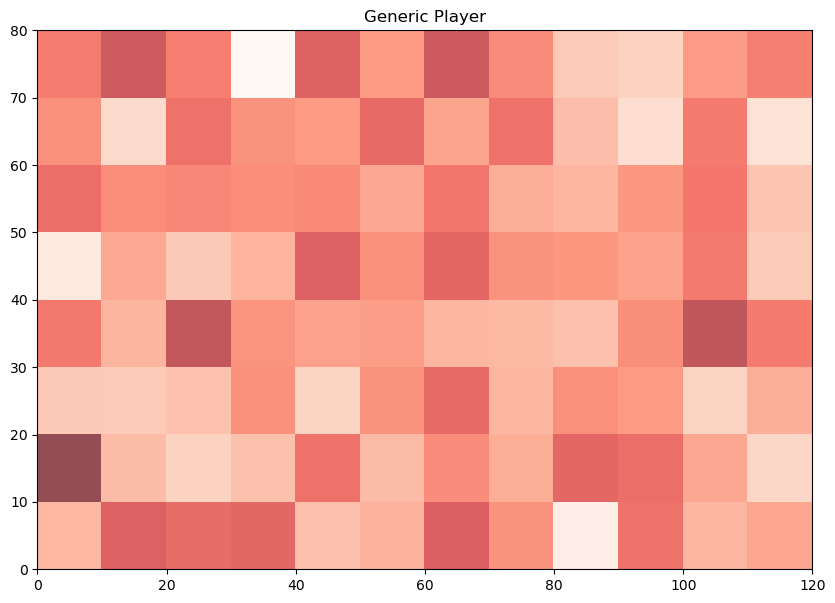

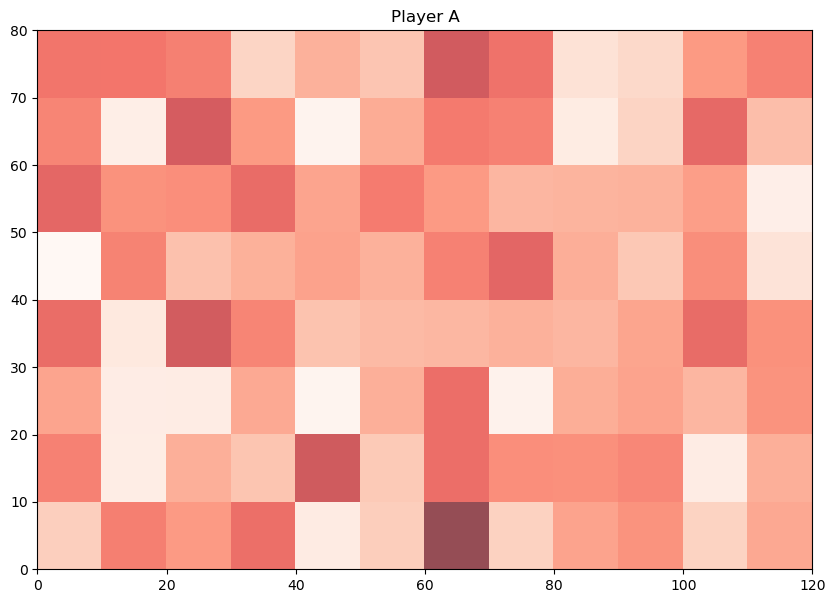

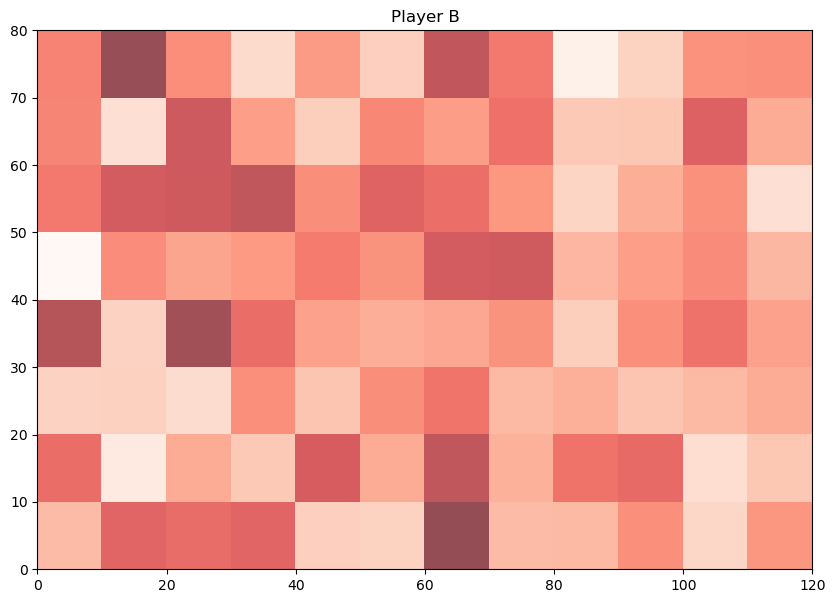

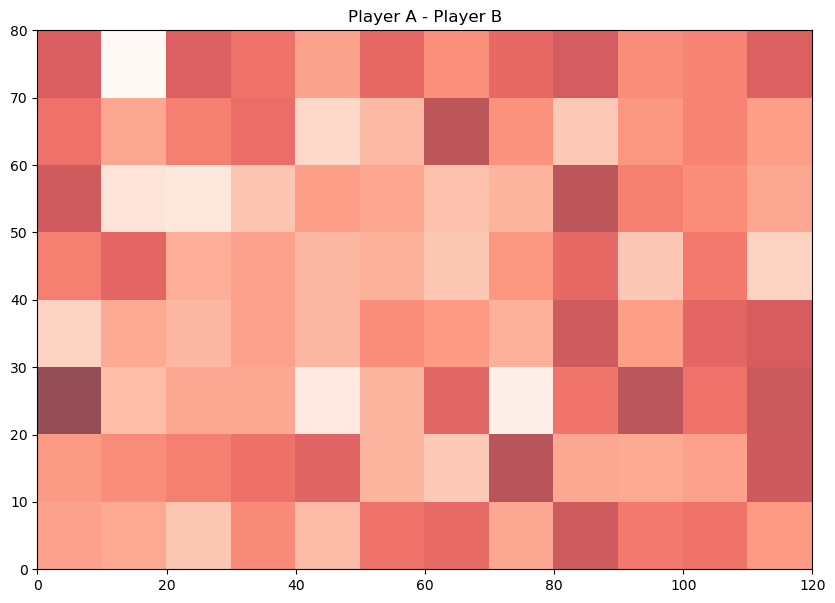

In [ ]:
# Choose one freeze-frame
sample_event = df.iloc[0]
grid = freeze_frame_to_grid(sample_event["freeze_frame"], sample_event["location"], N=12, M=8)

# Player IDs
player_A = 101
player_B = 202

# Surfaces
surf_avg = get_surface(model, grid, player_id=0)
surf_A = get_surface(model, grid, player_id=player_A)
surf_B = get_surface(model, grid, player_id=player_B)

# Plot
plot_surface(surf_avg, "Generic Player")
plot_surface(surf_A, "Player A")
plot_surface(surf_B, "Player B")

# Difference map (Player A - Player B)
diff = surf_A - surf_B
plot_surface(diff, "Player A - Player B", pitch_length=120, pitch_width=80)


In [42]:
import torch
from torch.utils.data import TensorDataset, DataLoader

def train_model(model, X, y, player_ids, epochs=5, batch_size=32, lr=1e-3, device="cpu"):
    """
    Minimal training loop for DecisionNet (CNN + embeddings).
    """
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    # Convert to torch tensors
    X_tensor = torch.tensor(X).permute(0, 3, 1, 2).float()  # (N, C, Ngrid, Mgrid)
    y_tensor = torch.tensor(y).long()
    pid_tensor = torch.tensor(player_ids).long()

    dataset = TensorDataset(X_tensor, y_tensor, pid_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for batch_X, batch_y, batch_pid in dataloader:
            batch_X, batch_y, batch_pid = batch_X.to(device), batch_y.to(device), batch_pid.to(device)

            optimizer.zero_grad()
            probs = model(batch_X, batch_pid)   # (batch, num_classes)
            loss = criterion(probs, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * batch_X.size(0)
            preds = probs.argmax(dim=1)
            correct += (preds == batch_y).sum().item()
            total += batch_y.size(0)

        avg_loss = total_loss / total
        acc = correct / total
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Acc: {acc:.4f}")

    return model


In [ ]:
num_players = 6000  # adjust to your dataset
model = DecisionNet(num_players=num_players, embed_dim=16, N=12, M=8, channels=3)

player_ids = [0] * len(y)

trained_model = train_model(model, X, y, player_ids, epochs=50, batch_size=64, lr=1e-3)


Epoch 1/50 - Loss: 4.5592, Acc: 0.0191
Epoch 2/50 - Loss: 4.5291, Acc: 0.0555
Epoch 3/50 - Loss: 4.5122, Acc: 0.0699
Epoch 4/50 - Loss: 4.5089, Acc: 0.0746
Epoch 5/50 - Loss: 4.5054, Acc: 0.0780
Epoch 6/50 - Loss: 4.5116, Acc: 0.0728
Epoch 7/50 - Loss: 4.5063, Acc: 0.0757
Epoch 8/50 - Loss: 4.4984, Acc: 0.0838
Epoch 9/50 - Loss: 4.4920, Acc: 0.0890
Epoch 10/50 - Loss: 4.4863, Acc: 0.0983
Epoch 11/50 - Loss: 4.4715, Acc: 0.1162
Epoch 12/50 - Loss: 4.4686, Acc: 0.1145
Epoch 13/50 - Loss: 4.4507, Acc: 0.1324
Epoch 14/50 - Loss: 4.4498, Acc: 0.1335
Epoch 15/50 - Loss: 4.4405, Acc: 0.1422
Epoch 16/50 - Loss: 4.4423, Acc: 0.1410
Epoch 17/50 - Loss: 4.4344, Acc: 0.1474
Epoch 18/50 - Loss: 4.4328, Acc: 0.1520
Epoch 19/50 - Loss: 4.4349, Acc: 0.1480
Epoch 20/50 - Loss: 4.4253, Acc: 0.1572
Epoch 21/50 - Loss: 4.4353, Acc: 0.1474
Epoch 22/50 - Loss: 4.4332, Acc: 0.1503
Epoch 23/50 - Loss: 4.4328, Acc: 0.1497
Epoch 24/50 - Loss: 4.4279, Acc: 0.1549
Epoch 25/50 - Loss: 4.4292, Acc: 0.1532
Epoch 26/